In [1]:
#packages
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [5]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()#
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i,interval = "1D", start=datetime(2018, 3, 1), end=datetime.today()).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data
ticks = ["BTC-USD",'ETH-USD','BNB-USD','SOL-USD','XRP-USD','ADA-USD']#,'AVAX-USD','TRX-USD','DOT-USD','MATIC-USD','LINK-USD']#,'ICP-USD','SHIB-USD','DOGE-USD','LTC-USD','STETH-USD','BCH-USD','ETC-USD','UNI7083-USD','OP-USD','ATOM-USD','LEO-USD','WEOS-USD','NEAR-USD','XLM-USD','LDO-USD','OKB-USD','INJ-USD','IMX10603-USD','FIL-USD','APT21794-USD','XMR-USD','HBAR-USD','BXC5168-USD','KAS-USD','MNT27075-USD','TIA22861-USD','STX4847-USD','VET-USD','CRO-USD','MKR-USD','BSV-USD','GRT6719-USD','RETH-USD','AAVE-USD','SEI-USD','RUNE-USD','HEX-USD','ALGO-USD','ORDI-USD','EGLD-USD','QNT-USD','RNDR-USD','TAO22974-USD','FLOW-USD','SUI20947-USD','MINA-USD','1000SATS-USD','HNT-USD','SNX-USD','FTM-USD','ZRX-USD','ZIL-USD','YGG-USD','XEM-USD','WOO-USD','WLD-USD','WAVES-USD','TRB-USD','TIA-USD','SKL-USD','SFP-USD','SAND-USD','RIF-USD','PYTH-USD','PERP-USD','PENDLE-USD','OGN-USD','MTL-USD','MASK-USD','MANA-USD','LUNA2-USD','LRC-USD','LOOM-USD','KNC-USD','KAVA-USD','JASMY-USD','IOST-USD','GMT-USD','GAS-USD','GALA-USD','FET-USD','EOS-USD','ENS-USD','DYDX-USD','CYBER-USD','CRV-USD','CHZ-USD','CFX-USD','CAKE-USD','C98-USD','BLZ-USD','BIGTIME-USD','BEL-USD','BAND-USD','AXS-USD','AUDIO-USD','ARPA-USD','ARB-USD','ALICE-USD','AGIX-USD','PEPE-USD','FLOKI-USD'] #Name of company (Dominos pizza)
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
(2198, 6)


,BTC-USD,ETH-USD,BNB-USD,SOL-USD,XRP-USD,ADA-USD
Date,,,,,,
2024-03-02,62029.847656,3422.049805,410.985870,129.700180,0.644851,0.740928
2024-03-03,63167.371094,3490.993652,414.381073,130.450867,0.627072,0.728238
2024-03-04,68330.414062,3630.433838,419.035431,133.194580,0.650133,0.771294
2024-03-05,63801.199219,3554.964600,394.661743,125.706711,0.592901,0.693490
2024-03-06,67213.492188,3859.806152,424.540222,130.217819,0.610820,0.725197


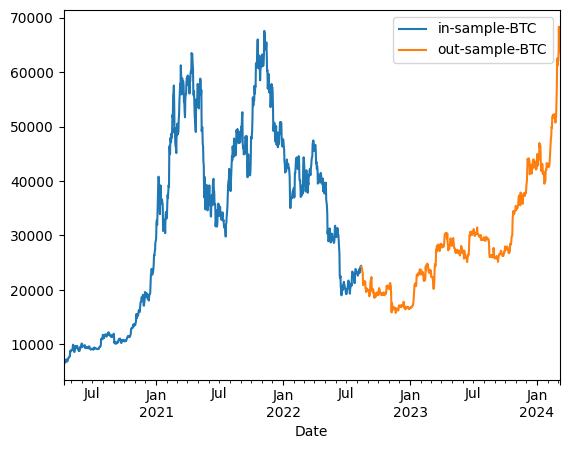

In [6]:
#data preperation
prices = d.dropna()
split = int(len(prices)*0.6)
outsample = prices[split:]
prices = prices[:split]
prices["BTC-USD"].plot(label='in-sample-BTC')
outsample["BTC-USD"].plot(label ='out-sample-BTC')
plt.legend()

In [45]:
#pure optimization method
#construction model
import pyomo.environ as pyo
model = pyo.ConcreteModel()
#parameters
N = prices.shape[1]
T = prices.shape[0]
model.N = pyo.Param(initialize = prices.shape[1]) #universe of assets #all dataset - index itself
model.T = pyo.Param(initialize = prices.shape[0]) #time duration
p       = np.array(prices).T
K = 2
#index sets
model.i = pyo.Set(initialize = np.arange(model.N))
model.j = pyo.Set(initialize = np.arange(model.N))
model.t = pyo.Set(initialize = np.arange(model.T))
# #variables
model.B0 = pyo.Var(domain = pyo.Reals)
model.B  = pyo.Var(model.j,domain = pyo.NonNegativeReals)
model.z= pyo.Var(model.i,model.j,domain = pyo.Binary)
# #objective and constraints
    # return sum(-model.B0 + np.log(P[t]) - sum(model.B[i]*np.log(p[i,t]) for i in model.i) for t in model.t)#linear
    # return sum((-model.B0 + np.log(P[t]) - sum(model.B[i]*np.log(p[i,t]) for i in model.i))**2 for t in model.t)#non linear !
def Obj(model):
    return sum((sum(sum((((p[i,t]) - model.B[j]*(p[j,t]) - model.B0)*(1-model.z[i,j]))**2 for j in model.j if i!=j)    for i in model.i) )   for t in model.t)
def Co1(model):
    return sum(((model.B[j]/(1+model.B[j]))*(1-model.z[i,j])) for i in model.i  for j in model.j if i!=j) <= 0.6
def Co2(model):
    return sum(model.z[i,j]   for i in model.i for j in model.j if i!=j) == (N**2)-N-1
# def Co3(model,t):
#     correlation of i,j >= 0.8

      
model.Obj = pyo.Objective(rule = Obj,sense = pyo.minimize)
model.Co1 = pyo.Constraint(rule = Co1)
model.Co2 = pyo.Constraint(rule = Co2)
# model.Co3 = pyo.Constraint(model.t,rule = Co3)


In [48]:
solver = pyo.SolverFactory('gams')
results = solver.solve(model,tee=True,solver = 'bonmin',add_options =['GAMS_MODEL.resLim = 500;'])
model.display()

--- Job model.gms Start 03/06/24 22:20:43 24.1.2 r40979 WEX-WEI x86_64/MS Windows
GAMS 24.1.2   Copyright (C) 1987-2013 GAMS Development. All rights reserved
Licensee: Gary Goldstein                                 G010614:2121CA-WIN
          Decision Ware, Inc.                                        DC2807
--- Starting compilation
--- model.gms(72) 5 Mb
--- model.gms(227) 6 Mb
--- Starting execution: elapsed 0:00:00.842
--- model.gms(129) 7 Mb
--- Generating MINLP model GAMS_MODEL
--- model.gms(133) 18 Mb
---   3 rows  38 columns  104 non-zeroes
---   231,364 nl-code  73 nl-non-zeroes
---   30 discrete-columns
--- model.gms(133) 17 Mb
--- model.gms(133) 15 Mb
--- Executing BONMIN (Solvelink=5): elapsed 0:00:01.044

COIN-OR Bonmin   24.1.2 r40979 Released Jun 16, 2013 WEI x86_64/MS Windows    

COIN-OR Bonmin (Bonmin Library trunk)
written by P. Bonami.

******************************************************************************
This program contains Ipopt, a library for large-scal

XRP-USD SOL-USD 0.003652586032537 0.405918246463617


array([0.99636071, 0.00363929])

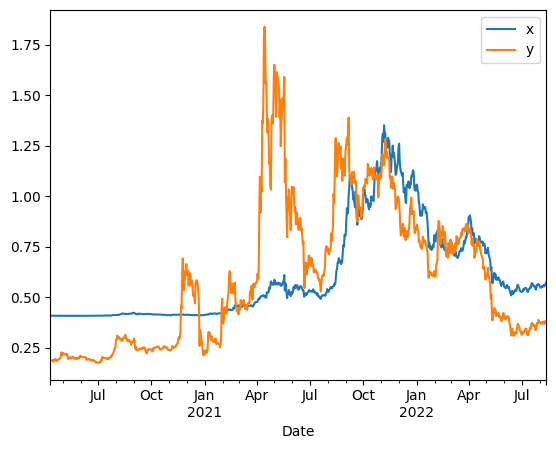

In [49]:
for i in model.i:
    for j in model.j:
        if model.z[i,j].value == 0:
            y,x,slope,intercept = ticks[i],ticks[j],model.B[j].value,model.B0.value
print(y,x,slope,intercept)
# (np.log(prices[x])*slope+intercept).plot(label = 'x')
# np.log(prices[y]).plot(label = 'y')
((prices[x])*slope+intercept).plot(label = 'x')
(prices[y]).plot(label = 'y')
w = np.array([1,slope])
w = w / sum(w)
plt.legend()
w

<AxesSubplot: xlabel='Date'>

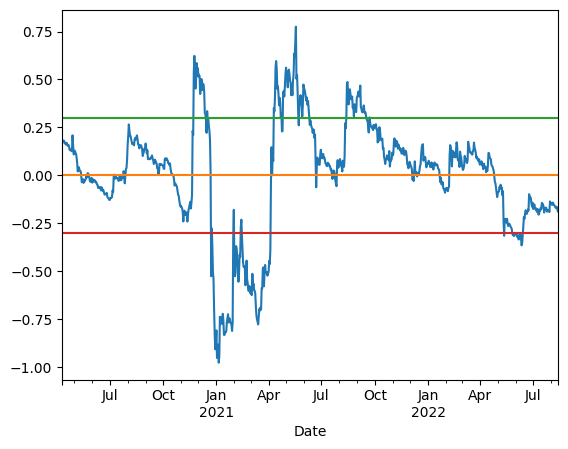

In [31]:
#displaying diff
diff = (np.log(prices[y])-((np.log(prices[x]))*slope+intercept))
diff.plot()
mean = pd.Series([diff.mean()] * len(diff),index = diff.index)
stdp  = pd.Series([diff.std()] * len(diff),index = diff.index)
stdn  = pd.Series([-1*diff.std()] * len(diff),index = diff.index)
mean.plot()
stdp.plot()
stdn.plot()

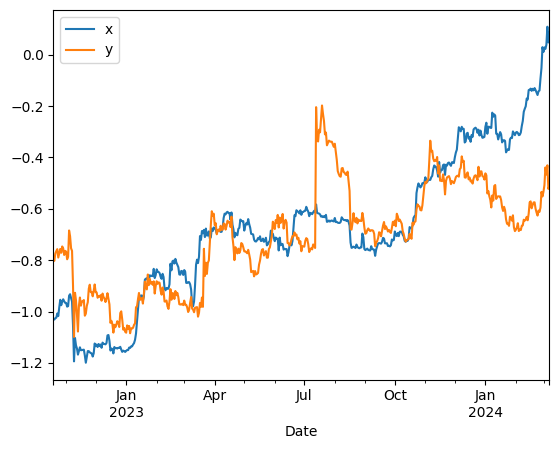

In [76]:
#out-of-sample log prices
(np.log(outsample[x])*slope+intercept).plot(label = 'x')
np.log(outsample[y]).plot(label = 'y')
plt.legend()
# (outsample[y]).plot(label = 'y')
# ((outsample[x])*slope+intercept).plot(label = 'x')

<AxesSubplot: xlabel='Date'>

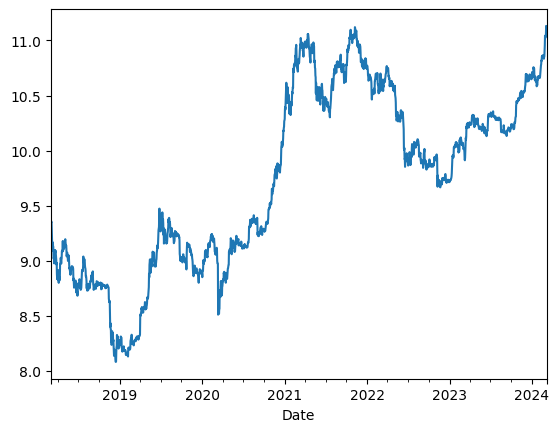

In [78]:
#our-of-sample real return


In [ ]:
trade = 0
position  = 0
ret_history = []
d = d.dropna()
for t in range(window, len(d)-1):
    data = d[t-window:t]
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
    #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
    #minimising the KPSS function (maximising the stationarity)
    res = spop.minimize(KPSS, b0, method='Nelder-Mead')
    KPSS_opt = res.fun
    #retrieving optimal parameters
    b_opt = float(res.x)
    a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])
    if trade == 1:
        if position == -1:
            ret = ((d[tickers[0]][t]/p0)-1) + ((d[tickers[1]][t]/p1)-1)*-1
        else:
            ret = -1*((d[tickers[0]][t]/p0)-1) + ((d[tickers[1]][t]/p1)-1)
        if ret < stop_loss:
            trade = 0
            position = 0
            ret_history.append(ret)
            print('stop loss',ret, tickers[1],':',d[tickers[1]][t],tickers[0],':',d[tickers[0]][t])
        if abs(d[tickers[1]][t]/(a_opt + b_opt*d[tickers[0]][t])-1) <= close:
            trade = 0
            position = 0
            print(ret)
            ret_history.append(ret)
            print('Close position:',tickers[1],':',d[tickers[1]][t],tickers[0],':',d[tickers[0]][t])
    else:
        # print(KPSS_opt,KPSS_max)
        if KPSS_opt <= KPSS_max :
            print('Cointegrated')
            if abs(d[tickers[1]][t]/(a_opt + b_opt*d[tickers[0]][t])-1) > entry:
                p0,p1 = d[tickers[0]][t] ,d[tickers[1]][t]
                trade = 1
                #print('Trade',tickers[1],':',d[tickers[1]][t],'Fair price 1:',a_opt + b_opt*d[tickers[0]][t])
                if d[tickers[1]][t] - (a_opt + b_opt*d[tickers[0]][t]) >0:
                    position = -1
                    print('sell',tickers[1],'buy',tickers[0])
                else:
                    position = 1
                    print('buy',tickers[1],'sell',tickers[0])
                print(tickers[1],':',d[tickers[1]][t],tickers[0],':',d[tickers[0]][t])
pd.Series(np.cumsum(ret_history)).plot()

In [ ]:
d = d.dropna()
for t in range(window, len(d)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = d[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(d[tickers[1]][t] - (a_opt + b_opt*d[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(d[tickers[1]][t]/(a_opt + b_opt*d[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(d[tickers[1]][t] - (a_opt + b_opt*d[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(d[tickers[0]][t-window:t-1])/np.array(d[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(d[tickers[1]][t-window:t-1])/np.array(d[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(d['market'][t-window:t-1])/np.array(d['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal

    #calculating returns
    gross = position0*(d[tickers[0]][t+1]/d[tickers[0]][t] - 1) + position1*(d[tickers[1]][t+1]/d[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    # market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)
#building the output dataframe
output = pd.DataFrame()
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
output['market'] = market_returns
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
plt.plot(np.append(1,np.cumprod(1+market_returns)))